# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 19
### <center> Yoshihiro Shirai

# Reinforcement Learning

- These lecture notes are based on various sources. 

- You may consult chapter 18 of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022," for a basic introduction to Reinforcement Learning.

- The main reference for the theory is "Reinforcement Learning: an Introduction, 2nd Edition, by Richard Sutton and Andrew Barto (MIT Press), 2018"

- Perhaps the best and quickest resource I know of is https://www.davidsilver.uk/teaching/

- For the Gymnasium API, which is one of the main interfaces for creating new environments, see https://gymnasium.farama.org/

- For training, I recommend https://stable-baselines3.readthedocs.io/en/master/index.html, an easy to use RL library that supports gym environments and has a good and active community.

# 0. Overview of the Lecture

- Basic ideas of reinforcement learning

- Review and construction of Gym environments

- Review of training libraries

# 1. Reinforcement Learning (RL)

- RL is a learning system that adapts its behavior based on the response received from the environment
    - The environment responses indicate which actions are good given a set of observations
    - It differs from supervised learning, because of the absence of a training set
    - It also differs from unsupervised learning, because of the presence of the response signal

- It is perhaps the most intuitive adaptation of a *game against nature*

## 1.1 Markov Decision Processes

- The simplest mathematical formulation of the problem an RL system solves is that of **Markov Decision processes** (MDP)

- Any method suitable to finding an optimal strategy within an MDP can be considered RL

- Formally, an MDP is a tuple $(S,A,P_a,R_a)$, where:
    - $S$ is a set of states, called the *state space*
    - $A$ is a set of actions, called the *action space*
    - $P_a(s,s')$ is the probability that the next observed state will be $s'$ given that the current observation is $s$ and the action is $a$
    - $R_a(s,s')$ is the reward received when transitioning to state $s'$ from state $s$ after action $a$ is taken

- The goal in a MDP is to find a good policy function $\pi:S\rightarrow \Delta^A$ that specifies the (mixed) strategy $\pi(s)$ to follow when state $s$ is observed
    - The environment then evolves as a Markov chain, since the next state only depends on the current state
    - The policy is chosen so as to maximize the expected discounted sum over all possible future rewards, i.e.
    \begin{align*}
    \mathbb{E}\left[G^{\pi}_0\right],
    \end{align*}
    where $\gamma$ is a discount factor and
    \begin{align*}
    G_t^{\pi}=\sum_{k=0}^{\infty}\gamma^{\tau}R_{\pi(s_{t+k})}(s_{t+k},s_{t+k+1})
    \end{align*}

- Note that it is assumed that the MDP never ends
    - This is without loss of generality since:
        - A terminal state $s_f$ may be defined as any state such that $p_a(s_f,s_f)=1$ 
        - If a terminal state $s_f$ is reached, the reward $R_a(s_f,s_f)$ is zero for any action $a$

- We next discuss a few ways to find an optimal policy $\pi$

## 1.2 Optimal Policies

- Given a policy $\pi$, define:
    - the **value function** $V^{\pi}:S\rightarrow \mathbb{R}$ by
    \begin{align*}
    V^{\pi}(s):=\mathbb{E}[G^{\pi}_t|s_t=s]
    \end{align*}
    - the **action-value function** $q^{\pi}:S\times A\rightarrow \mathbb{R}$ by
    \begin{align*}
    q^{\pi}(s,a):=\mathbb{E}[R_{a}(s_t,s_{t+1})+V^{\pi}(s_{t+1})|s_t=s],
    \end{align*}

- Note that:
\begin{align}
V^{\pi}(s)&=\mathbb{E}[R_{\pi(s)}(s,s_{t+1})+\gamma V^{\pi}(s_{t+1})|s_t=s] \\
q^{\pi}(s,a)&=\mathbb{E}[R_{a}(s,s_{t+1})+\gamma q^{\pi}(s_{t+1},\pi(s_{t+1}))|s_t=s,a_t=a]
\end{align}

- A policy $\pi^*$ is optimal if it satisfies $V^{\pi^*}(s)=\sup_{\pi}V^{\pi}(s)$ for all $s\in S$, where the supremum is taken over all policies $\pi$

- Let $V^*=\sup_{\pi}V^{\pi}$ and $q^*=\sup_{\pi}q^{\pi}$

- Then, an optimal policy is given by
\begin{align*}
\pi^*(a|s)=\begin{cases}
1 \text{ if } a = \text{arg}\max_aq^*(s,a)\\
0 \text{ otherwise } 
\end{cases}
\end{align*}
so, in particular, it is also possible to find a deterministic optimal policy, once $q^*$ is known

- From equation (2) and the Markov property, $q^*$ solves the Bellman equation
\begin{align*}
q^*(s,a)=\mathbb{E}\left[R_a(s,s_{t+1})+\max_a q^*(s_{t+1},a)|s_t=s\right] \tag{3}
\end{align*}

- Or, in terms of the value function $v^{*}$, 
\begin{align*}
v^*(s)=\max_a\mathbb{E}[R_a(s,s_{t+1})+\gamma v^*(s_{t+1})|s_t=s,a_t=a]\tag{4}
\end{align*}

- If there are $N$ states, then (3) (or, equivalently, (4)) is a system of $N$ equations in $N$ unknowns, and can be solved numerically if the transition dynamics $p$ is known

## 1.3 Dynamic Programming (DP)

- Suppose that each element of an MDP is fully known

- Any method to solve the Bellman equation (3) is considered DP

- Typically, we do not know tha transition dynamics $p$ of an MDP

- However, the DP approach is the starting point of many RL algorithms, so it's good to take a look at it

### 1.3.1 Evaluating policies

- First, we need a method to evaluate $v^{\pi}$ and $q^{\pi}$ for a given policy function $\pi$. 
    - This can be done as follows. For an initial guess $v_0$ for $v^{\pi}$, let
    \begin{align*}
    v_{k+1}(s)=\mathbb{E}\left[R_{\pi(s)}(s,s_{t+1})+ v_{k}(s_{t+1})|s_t=s\right] \tag{4}
    \end{align*}
    - Then, it can be shown that $v_{k}\rightarrow v^{\pi}$.
    - Similarly one can evaluate $q^{\pi}$.

### 1.3.2 The Policy Improvement Theorem

- Now given a policy, suppose that, in some state $s$, it is better to choose an action $a\neq \pi(s)$, and then follow $\pi$, rather than simply following $\pi$

- Is this new strategy better than just following $\pi$?

- Formally, we would like to know if
\begin{align*}
q^{\pi}(s,\pi'(s))\geq v^{\pi}(s) \Rightarrow v^{\pi'}(s)\geq v^{\pi}(s)
\end{align*}

- This turns out to be true, and such result is known as the ***Policy Improvement Theorem***

- The proof of the Policy Improvement Theorem is simple:
\begin{align*}
v^{\pi}(s)
&\leq q^{\pi}(s,\pi'(s))\\
&=\mathbb{E}[R_{\pi'(s)}(s,s_{t+1})+\gamma v^{\pi}(s_{t+1})]\\
& \leq \mathbb{E}[R_{\pi'(s)}(s,s_{t+1})+\gamma q^{\pi}(s_{t+1},\pi'(s_{t+1}))|s_t=s]\\
& = \mathbb{E}[R_{\pi'(s)}(s,s_{t+1})+R_{\pi'(s_{t+1})}(s_{t+1},s_{t+2})+\gamma v^{\pi}(s_{t+2})|s_t=s]\\
&...\\
&\leq \mathbb{E}\left[\sum_{k=0}^{\infty}R_{\pi'(s_{t+k})}(s_{t+k},s_{t+k+1})\right]\\
& = v^{\pi'}(s).
\end{align*}

### 1.3.3 Policy Iteration

- A policy $\pi$ can be improved by the *greedy* policy $\pi'$ that maximizes the short term action, i.e.
\begin{align*}
\pi'(s)=\text{arg}\max_aq^{\pi}(s,a)
\end{align*}
since, by the Policy Improvement Theorem, it must be the case that $v^{\pi'}(s)\geq v^{\pi}(s)$ for every $s\in S$. 

- If $\pi'=\pi$, i.e. acting greedily does not improve the value function, then
\begin{align*}
v^{\pi}(s)=\max_a\mathbb{E}[R_a(s,s_{t+1})+\gamma v^{\pi}(s_{t+1})|s_t=s,a_t=a],
\end{align*}
i.e., $\pi$ satisfies the Bellman optimality principle, and so $\pi=\pi^*$

- Hence, a strategy to obtain $\pi^*$ is to start with a random policy $\pi_0$, evaluate $v^{\pi_0}$, obtain the Bellman update $\pi_1$ by acting greedily on $\pi_0$, evaluate $v^{\pi_1}$, obtain the Bellman update $\pi_2$ by acting greedily on $\pi_1$, and so on.

- It is actually possible to show that such an iteration indeed converges to a policy $\pi^*$ which is optimal

- The algorithm is shown in the figure below

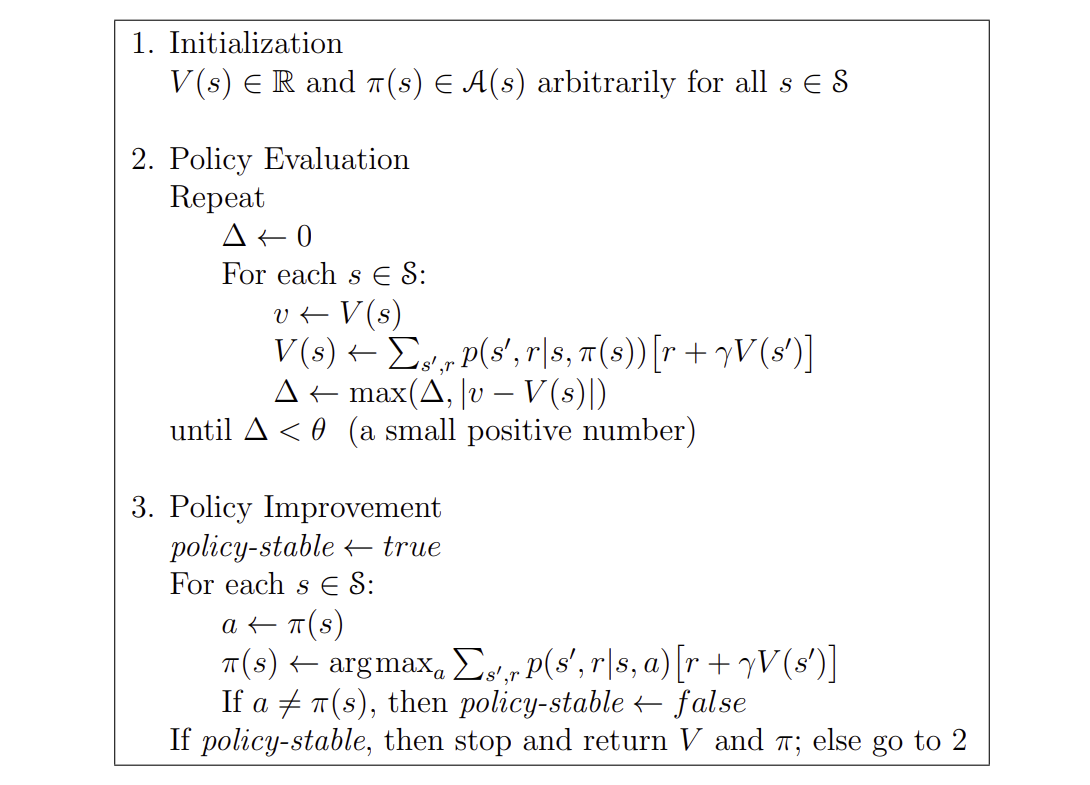

In [2]:
from IPython.display import Image
Image("Figs/PolicyIteration.png",width=700)

# Gymnasium

### Basic Installation:

- Gymnasium is a standard API for reinforcement learning, and a diverse collection of reference environments.

- It is maintained and updated by the Farama foundation. See https://gymnasium.farama.org/

- To install it, run `pip install gymnasium`

- This installation does not include dependencies for all families of environments. 
    - You can install the dependencies that you need, e.g. `pip install gymnasium[atari]` for atari games or `pip install gymnasium[box2d]` for  Box2D, which allows you to render your environment. 
    - To install all dependencies, run `pip install "gymnasium[all]`.

### Examples
Let's look at a few environments that are already available in the gymnasium library. 

First, we need to import gymnasium.



In [1]:
import gymnasium as gym

Now, let's look at some examples of the built in environments in gymnasium.

A good explanation of the codes below is at https://towardsdatascience.com/creating-a-custom-gym-environment-for-jupyter-notebooks-e17024474617

In [2]:
# Example 1: open lunar lander

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(5):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [3]:
#Example 2: CartPole

###########################################
#         Stage 1 - Initialization
###########################################

# create the cartpole environment
env = gym.make('CartPole-v1', render_mode="human")

# run for 10 episodes
for episode in range(5):

  # put the environment into its start state
  env.reset()

###########################################
#            Stage 2 - Execution
###########################################

  # run until the episode completes
  terminated = False
  while not terminated:

    # show the environment
    env.render()

    # choose a random action
    action = env.action_space.sample()

    # take the action and get the information from the environment
    observation, reward, terminated, truncated, info = env.step(action)


###########################################
#           Stage 3 - Termination
###########################################

# terminate the environment
env.close()

It is also possible to input actions directly:

In [4]:
# Example 3: play car racing
# use arrows to play. to exit press esc

%run C:\Users\yshirai\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\box2d\car_racing.py

Exception: File `'C:\\Users\\yshirai\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\gymnasium\\envs\\box2d\\car_racing.py'` not found.

## Training Environments

To be explored. See https://gymnasium.farama.org/tutorials/training_agents/

## Creating a Custom Gymnasium Environment

Next we show an example of how to construct a custom environment that implements the Gymnasium interface.

All that’s required is a class that inherits from the Gym environment and that adds the set of functions described above.

The example is taken again from https://towardsdatascience.com/creating-a-custom-gym-environment-for-jupyter-notebooks-e17024474617

In [5]:
import numpy as np
from gymnasium.spaces import Discrete,MultiDiscrete


class BabyRobotEnv_v1(gym.Env):

    def __init__(self, **kwargs):
        super().__init__()

        # dimensions of the grid
        self.width = kwargs.get('width',3)
        self.height = kwargs.get('height',3)

        # define the maximum x and y values
        self.max_x = self.width - 1
        self.max_y = self.height - 1

        # there are 5 possible actions: move N,E,S,W or stay in same state
        self.action_space = Discrete(5)

        # the observation will be the coordinates of Baby Robot
        self.observation_space = MultiDiscrete([self.width, self.height])

        # Baby Robot's position in the grid
        self.x = 0
        self.y = 0

    def step(self, action):
        obs = np.array([self.x,self.y])
        reward = -1
        done = True
        truncated = False
        info = {}
        return obs, reward, done, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # reset Baby Robot's position in the grid
        self.x = 0
        self.y = 0
        info = {}
        return np.array([self.x,self.y]),info

    def render(self):
        pass


In [1]:
# create an instance of our custom environment
env = BabyRobotEnv_v1()


# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
# from gymnasium.utils.env_checker import check_env
# check_env(env)

NameError: name 'BabyRobotEnv_v1' is not defined

In [7]:
print(f'Action Space: {env.action_space}')
print(f'Action Space Sample: {env.action_space.sample()}')

print(f'Observation Space: {env.observation_space}')
print(f'Observation Space Sample: {env.observation_space.sample()}')

Action Space: Discrete(5)
Action Space Sample: 0
Observation Space: MultiDiscrete([3 3])
Observation Space Sample: [0 1]


### For future: setup script file for own environment class

Ideally, one would like to have our custom environment registered as a proper Gymnasium environment, that can be created using ‘gymnasium.make’. In this case, one needs to create appropriate directories, which can be done through the setuptools library, as well as the appropriate .py files. Many other steps may be required for the ultimate product, such being able to simply install babyrobot environment using pip. Also, once this is done, what do we do to actually run it?

It is still not clear to me how to do all this.

For the babyrobot environment, one can download the full github codes at https://github.com/WhatIThinkAbout/BabyRobotGym. The setup.py file should install the directories, which is the first step.


### For Future: create graphical rendering

To get more than just a single vector as final output, one needs to construct graphics for the environment. This is done for the babyrobot env at https://towardsdatascience.com/creating-a-custom-gym-environment-for-jupyter-notebooks-e8718f36547b

I leave this for later.

# Box2D Environment

For our satellites project, the discrete and multidiscrete spaces of babyrobot will not be enough.

For instance, the satellites visual cone is a polygon in Box2d, and it would be consuming too much time replicating it in the multidiscrete class. Also it seems that collisions were already modelled there.

First we go through the basic hello box2d example from the documentation in https://box2d.org/documentation/index.html

In [8]:
import Box2D

### Step 1: create a world

Every Box2D program begins with the creation of a b2World object.

b2World is the physics hub that manages memory, objects, and simulation.

You can allocate the physics world on the stack, heap, or data section.

In [9]:
g = (0,-10) # direction and magnitude of movement of each dynamic body at each point in time

#world = Box2D.b2World(gravity=g, doSleep=True)
world = Box2D.b2World(gravity=g)

#checks:
print('Total body count = ',world.bodyCount)
print('Gravity vector = ',world.gravity)

Total body count =  0
Gravity vector =  b2Vec2(0,-10)


### Step 2: Create a ground (i.e. static) body with the shape of a box and no mass

Bodies are built using the following steps:
1. Define a body with position, damping, etc.
2. Use the world object to create the body
3. Define fixtures with a shape, friction, density, etc.
4. Create fixtures on the body

In [10]:
# 1
p = (0.0,-9)
groundBodyDef = Box2D.b2BodyDef(position = p)

# 2
GroundBody = world.CreateBody(groundBodyDef)

# CreateBody creates a body in the world.
#         Takes a single b2BodyDef argument, or kwargs to pass to a temporary b2BodyDef.
#         world.CreateBody(position=(1,2), angle=1) 
#         is short for:
#         world.CreateBody(b2BodyDef(position=(1,2), angle=1))

#         If the definition (or kwargs) sets 'fixtures', they will be created on the 
#         newly created body. A single fixture is also accepted.

#         CreateBody(..., fixtures=[])

#         This is short for:
#             body = CreateBody(...)
#             for fixture in []:
#                 body.CreateFixture(fixture)

#          'shapes' and 'shapeFixture' are also accepted:
#          CreateBody(..., shapes=[], shapeFixture=b2FixtureDef())

#         This is short for:
#             body = CreateBody(...)
#             body.CreateFixturesFromShapes(shapes=[], shapeFixture=b2FixtureDef())

# 3
groundBox = Box2D.b2PolygonShape(box = (50,10))

# 4
GroundBody.CreateFixture(shape = groundBox)

b2Fixture(body=b2Body(active=True,
                      angle=0.0,
                      angularDamping=0.0,
                      angularVelocity=0.0,
                      awake=True,
                      bullet=False,
                      contacts=[],
                      fixedRotation=False,...  ),
          density=0.0,
          filterData=categoryBits=1,groupIndex=0,maskBits=65535,),
          friction=0.20000000298023224,
          massData=I=0.0,center=b2Vec2(0,0),mass=0.0,),
          restitution=0.0,
          sensor=False,
          shape=b2PolygonShape(vertices: [(-50.0, -10.0), (50.0, -10.0), (50.0, 10.0), (-50.0, 10.0)]),
          type=2,
          userData=None,
          )

In [11]:
#checks:
print('Total body count = ',world.bodyCount)
print('Gravity vector = ',world.gravity)

Total body count =  1
Gravity vector =  b2Vec2(0,-10)


### Step 3: Create a Dynamic Body

So now we have a ground body. We can use the same technique to create a dynamic body. The main difference, besides dimensions, is that we must establish the dynamic body's mass properties.

First we create the body using CreateBody. By default bodies are static, so we should set the b2BodyType at construction time to make the body dynamic.

In [12]:
# Create a dynamic body with position p
p = (0.0,4.0)
Body = world.CreateDynamicBody(position=p) #CreateDynamicBody does not seem to accept the intermediate step 1 used above with CreateBody (where it optional)

# create its shape fixture
DynamicBox = Box2D.b2PolygonShape(box = (1,1))

# attach the shape fixture to the body, along with other fixtures
Body.CreateFixture(shape = DynamicBox, density = 1, friction = 0.3)

#checks:
print('Total body count = ',world.bodyCount)
print('Gravity vector = ',world.gravity)

Total body count =  2
Gravity vector =  b2Vec2(0,-10)


### Simulating the World
After setting up the static box and the dynamic one, we can let gravity do its job, and we should see the dynamic box fall into the static one. 



As physics laws are solved each time step, the 

In [13]:
timeStep = 1/60 #Time step is set at 60 Hertz (1/60 seconds)
velocityIterations = 6 #Max iterations to correctly infer velocity from physics laws at each time st
positionIterations = 2 #Max iterations to correctly infer position from physics laws at each time step

for i in range(0,600):
    world.Step(timeStep, velocityIterations, positionIterations)
    position = Body.position
    angle = Body.angle
    print("{:.2f}".format(position.x), "{:.2f}".format(position.y), "{:.2f}".format(angle))


0.00 4.00 0.00
0.00 3.99 0.00
0.00 3.98 0.00
0.00 3.97 0.00
0.00 3.96 0.00
0.00 3.94 0.00
0.00 3.92 0.00
0.00 3.90 0.00
0.00 3.87 0.00
0.00 3.85 0.00
0.00 3.82 0.00
0.00 3.78 0.00
0.00 3.75 0.00
0.00 3.71 0.00
0.00 3.67 0.00
0.00 3.62 0.00
0.00 3.57 0.00
0.00 3.52 0.00
0.00 3.47 0.00
0.00 3.42 0.00
0.00 3.36 0.00
0.00 3.30 0.00
0.00 3.23 0.00
0.00 3.17 0.00
0.00 3.10 0.00
0.00 3.02 0.00
0.00 2.95 0.00
0.00 2.87 0.00
0.00 2.79 0.00
0.00 2.71 0.00
0.00 2.62 0.00
0.00 2.53 0.00
0.00 2.44 0.00
0.00 2.35 0.00
0.00 2.25 0.00
0.00 2.15 0.00
0.00 2.05 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 0.00
0.00 2.01 

Note: the body stops falling at level 2, as that is where its lower edge collides with the upper edge of the ground body 

In fact, recall that the ground body is positioned at (0,-10), with upper vertices at (0,-10)+(50,10) and (0,-10)+(-50,10), and similarly for the dynamic body.